In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import seaborn as sns
from skimage.util import montage as montage2d
from skimage.io import imread
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
import cv2

Using TensorFlow backend.
/Users/swchoi1994/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/swchoi1994/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/swchoi1994/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/swchoi1994/opt/anacond

In [2]:
x_ray_data = pd.read_csv('df_AP.csv')
x_ray_data.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168,=NA()
1,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,=NA()
2,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,=NA()
3,00000032_003.png,No Finding,3,32,55,F,AP,2500,2048,0.168,0.168,=NA()
4,00000032_004.png,Edema,4,32,55,F,AP,2500,2048,0.168,0.168,=NA()
5,00000032_004.png,Effusion,4,32,55,F,AP,2500,2048,0.168,0.168,=NA()
6,00000032_004.png,Cardiomegaly,4,32,55,F,AP,2500,2048,0.168,0.168,=NA()
7,00000032_005.png,No Finding,5,32,55,F,AP,2500,2048,0.168,0.168,=NA()
8,00000032_006.png,Atelectasis,6,32,55,F,AP,2500,2048,0.168,0.168,=NA()
9,00000032_006.png,Infiltration,6,32,55,F,AP,2500,2048,0.168,0.168,=NA()


In [3]:
num_obs = len(x_ray_data)
print('Number of observations:',num_obs)

Number of observations: 5381


In [4]:
from keras.models import load_model

In [5]:
train_df = pd.read_csv("NIH/train-small.csv")
valid_df = pd.read_csv("NIH/valid-small.csv")

test_df = pd.read_csv("NIH/test.csv")

In [6]:
train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [7]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
import torch
from torchvision import datasets,transforms, models
from collections import OrderedDict

In [10]:
import time
from torch import nn
from torch import optim

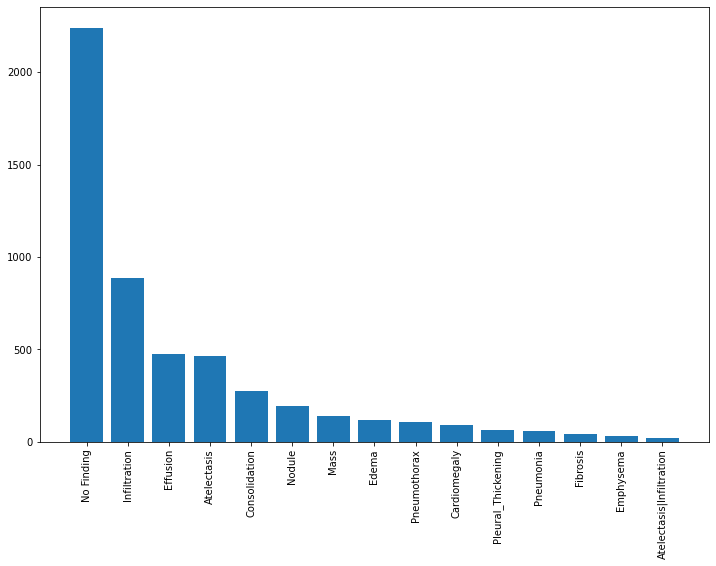

In [11]:
label_counts = x_ray_data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)


In [12]:
x_ray_data['Finding Labels'] = x_ray_data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*x_ray_data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        x_ray_data[c_label] = x_ray_data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
#x_ray_data.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [14]:
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if x_ray_data[c_label].sum()>MIN_CASES]

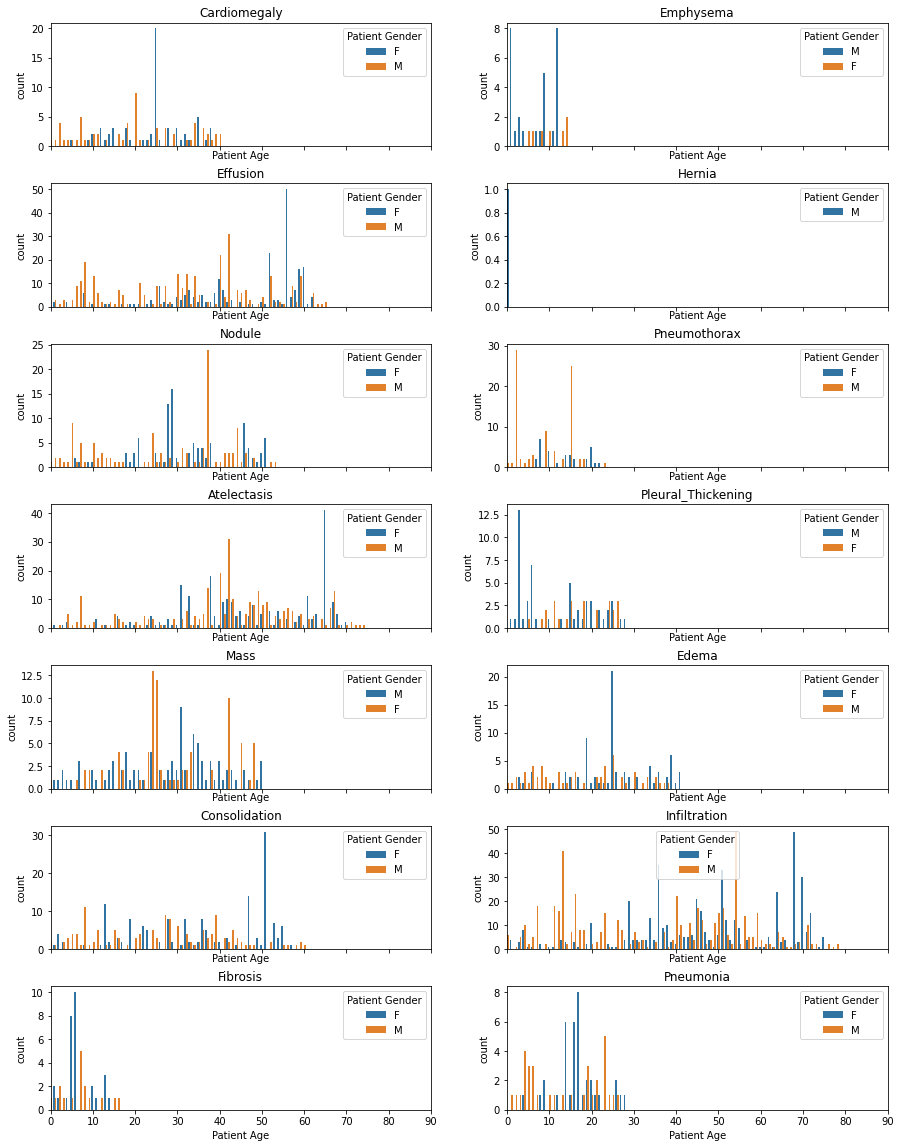

In [21]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
df = x_ray_data[x_ray_data['Finding Labels'] != 'No Finding']
i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    index = []
    for k in range(len(df)):
        if pathology in df.iloc[k]['Finding Labels']:
            index.append(k)
    g=sns.countplot(x='Patient Age', hue="Patient Gender",data=df.iloc[index], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

ValueError: Could not interpret input '	Finding Labels'

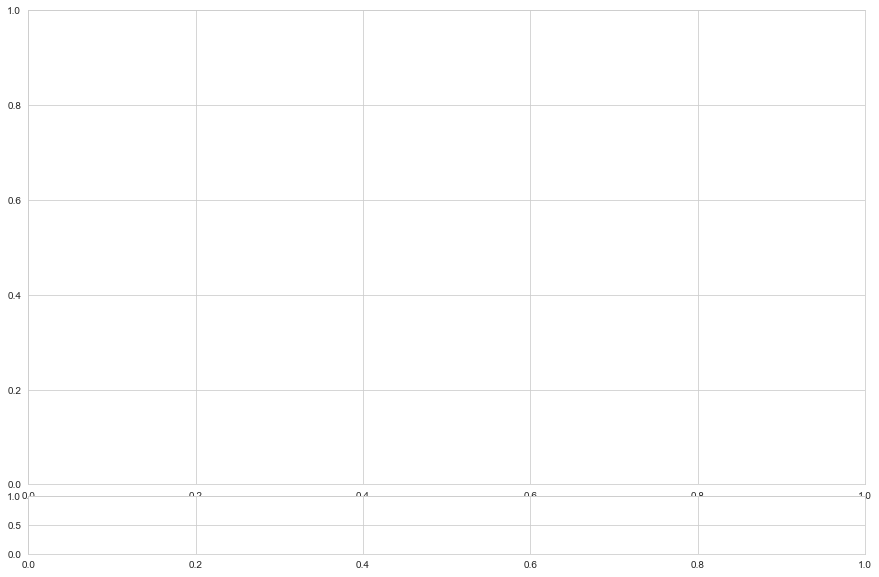

In [26]:
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(x_ray_data,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Finding Labels',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='	Finding Labels',hue='Patient Gender',x_ray_data=data1, ax=ax1, order = data1['Finding Labels'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

x_ray_data['Nothing']=x_ray_data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(x_ray_data,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Finding Labels',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Finding Labels',hue='Patient Gender',x_ray_data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)